<a href="https://colab.research.google.com/github/KDOXG/Inteligencia-Artificial/blob/master/MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MNIST Convolutional Neural Network**


<img src="https://www.researchgate.net/profile/Steven_Young11/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png" width="250" />

[Dataset link](http://yann.lecun.com/exdb/mnist/)

In [0]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [0]:
print(torch.__version__)

1.3.0+cu100


In [0]:
BATCH_SIZE = 32

transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

In [0]:
print(trainset)
print(testset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


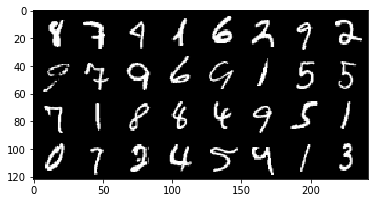

In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [0]:
for images, labels in train_loader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv1_bn = nn.BatchNorm2d(6)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)

        self.fc1 = nn.Linear(16 * 4 * 4, 125)
        self.fc2 = nn.Linear(125, 90)
        self.fc3 = nn.Linear(90, 10)

        self.activation_function = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        
        x = self.activation_function(self.conv1(x))
        x = self.conv1_bn(x)
        x = self.pool(x)
        
        # x = self.dropout(x)
        
        x = self.activation_function(self.conv2(x))
        x = self.conv2_bn(x)
        x = self.pool(x)

         # x = self.dropout(x)
        x = x.view(-1, 16 * 4 * 4)
        
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        x = self.activation_function(self.fc3(x))
        #x = self.fc3(x)
        
        return x

In [0]:
## test the model with 1 batch
model = CNN()
for images, labels in train_loader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [0]:
model = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=125, bias=True)
  (fc2): Linear(in_features=125, out_features=90, bias=True)
  (fc3): Linear(in_features=90, out_features=10, bias=True)
  (activation_function): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [0]:
learning_rate = 0.001
epochs = 15

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

In [0]:
train_losses = []
running_losses_list = []
train_accuracy_list = []

for epoch in range(epochs):
    i = 0
    running_loss = 0.0
    accuracy = 0.0
    total = 0
    correct = 0

    model.train()
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        
        train_losses.append(loss.item())
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    model.eval()
    accuracy = correct / total
    train_accuracy_list.append(accuracy)
    running_losses_list.append(running_loss)

    print("Epoch: %5d \t Loss: %.5f \t Accuracy: %.5f" %(epoch+1, running_loss, accuracy))

Epoch:     1 	 Loss: 1843.34305 	 Accuracy: 0.65362
Epoch:     2 	 Loss: 1365.82126 	 Accuracy: 0.70255
Epoch:     3 	 Loss: 1330.36815 	 Accuracy: 0.70512
Epoch:     4 	 Loss: 1184.81004 	 Accuracy: 0.74222
Epoch:     5 	 Loss: 937.83770 	 Accuracy: 0.79555
Epoch:     6 	 Loss: 920.76512 	 Accuracy: 0.79650
Epoch:     7 	 Loss: 911.31247 	 Accuracy: 0.79750
Epoch:     8 	 Loss: 904.61058 	 Accuracy: 0.79782
Epoch:     9 	 Loss: 899.83830 	 Accuracy: 0.79820
Epoch:    10 	 Loss: 895.47377 	 Accuracy: 0.79845
Epoch:    11 	 Loss: 892.15538 	 Accuracy: 0.79888
Epoch:    12 	 Loss: 888.49596 	 Accuracy: 0.79957
Epoch:    13 	 Loss: 886.31172 	 Accuracy: 0.79972
Epoch:    14 	 Loss: 882.93539 	 Accuracy: 0.80007
Epoch:    15 	 Loss: 879.66994 	 Accuracy: 0.80025


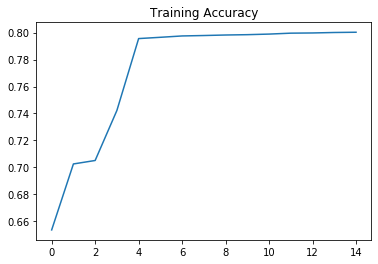

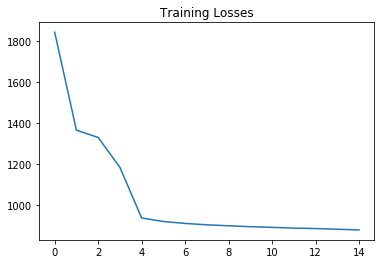

In [0]:
plt.plot(train_accuracy_list, label='')
plt.title("Training Accuracy")
plt.show()

plt.plot(running_losses_list, label='')
plt.title("Training Losses")
plt.show()

In [0]:
test_losses = []
test_accuracies = []
y_true = []
y_pred = []
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        test_losses.append(loss.item())
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.flatten().tolist())
        y_pred.extend(predicted.flatten().tolist())
        
accuracy = correct / total

#test_accuracies.append(accuracy)
print('Epochs: {} \t Train Loss: {:.4f} \t Test Loss: {:.4f} \t Test Accuracy: {:.2f}'\
     .format(epoch+1, np.mean(train_losses), np.mean(test_losses), accuracy))

Epochs: 15 	 Train Loss: 0.5555 	 Test Loss: 0.4907 	 Test Accuracy: 0.80


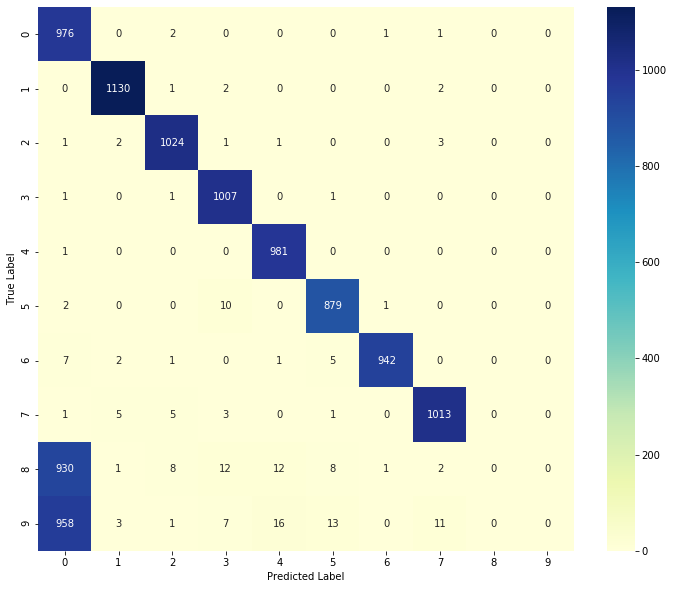

In [0]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(12,10))
ax = sn.heatmap(df_cm, annot=True, cmap=plt.cm.YlGnBu, fmt='d')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()